In [1]:
"""
*Filename: SecondaryVertexDeepSetTrainer
*Description: This jupyter notebook is an extension of the ProjectorTrainer, it trains the same
*residual deep sets neural network architecture as the projector trainer with the additional
*features as well. In addition it adds the secondary vertex displacement of the b_jets as an
*additional target for the network to converge to.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-19 13:31:03.527434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 13:31:03.721060: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-19 13:31:03.725326: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-19 13:31:03.725346: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
SV_features = ["TruthParticles_Selected_LxyT"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + SV_features, entry_stop=MAXEVENTS)

In [7]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [8]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [9]:
# Select tracks from the events
tracks = events[track_features]
Secondary_Displacement_temp_first = events[SV_features]

# Match the tracks to the jets
mask = DSNNA.Match_Tracks(jets, tracks)
matchedtracks = tracks[mask]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [10]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
Secondary_Displacement_temp_a = DSNNA.flatten(Secondary_Displacement_temp_first, 6).to_numpy()
Secondary_Displacement_temp_b = Secondary_Displacement_temp_a[:,0]
Secondary_Displacement_temp = Secondary_Displacement_temp_b[bjets]
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [11]:
#Selects the secondary displacement of the first particle in the structured dataset
Secondary_Displacement = np.array([x[0] for x in Secondary_Displacement_temp])
print(np.min(Secondary_Displacement), np.max(Secondary_Displacement))

-999.0 115.98360443115234


In [12]:
np.where(Secondary_Displacement == -999)
Secondary_Displacement[365]

-999.0

In [13]:
print(Secondary_Displacement_temp_first[408,0])

{TruthParticles_Selected_LxyT: 1.65}


In [14]:
for index in range(len(jets)):
    if Secondary_Displacement_temp_a[index,0][0] == -999:
        print(index)

732
967
1136
1151
1249
1286
1584
1806
2089
2121
2177
2385
2490
2501
2788
2830
2920
3028
3122
3150
3172
3223
3359
3837
4327
4386
4649
4810
5031
5356
5685
5691
5704
6024
6091
6105
6357
6363
6481
6662
7173
8281
8601
8871
8889
9218
9279
9609
9921
9932
10149
10152
10317
10411
10461
10515
10560
10575
10586
10853
10889
10965
11087
11133
11844
12085
12158
12222
12375
12391
12399
12465
12808
12839
12863
13190
13312
13415
13435
13450
13455
13610
13613
13672
13799
14182
14199
14532
14538
14689
14713
15192
15442
15524
15626
15723
15800
15925
16098
16149
16242
16404
16584
16700
16705
17001
17194
17322
17508
18155
18225
18810
19204
19214
19462
19734
19844
20881
21051
21123
21190
21217
21249
21482
21865
21892
22075
22162
22838
22898
22900
22998
23056
23078
23116
23379
23428
23602
23659
23765
23882
24003
24054
24130
24322
24435
24475
24518
24556
24576
24719
24922
25197
25504
25901
26003
26034
26167
26355
26480
26556
26570
26588
26683
26822
26971
27278
27299
27402
27547
27810
28236
28271
28323
28447
28

In [15]:
print(events["AnalysisAntiKt4TruthJets_ghostB_pdgId"][16,0])
print(events["TruthParticles_Selected_LxyT"][16,0])

[]
2.628993272781372


In [16]:
print(Secondary_Displacement_temp_a[734])
print(bhads_PGID[733])

[( 0.00000000e+00,) ( 7.34730601e-01,) ( 4.74455170e-02,)
 ( 2.77990192e-01,) ( 9.80036259e-01,) (-9.99000000e+02,)]
-511


In [17]:
print(Secondary_Displacement_temp_b[732])

(-999.,)


In [159]:
bjets[732]

True

In [94]:
Secondary_Displacement_temp[5]

(1.71670938,)

In [18]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [19]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:108: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [20]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)

In [21]:
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(96659,)


In [22]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(96659, 3)


In [23]:
print(bhads_fractions_px.shape)
print(Secondary_Displacement.shape)

(96659,)
(96659,)


In [24]:
#Identify the outliers in the dataset and remove them to prevent spikes during learning.
print(np.max(bhads_fractions), np.min(bhads_fractions_px))
array = [x for x in range(bhads_fractions_px.shape[0])]

#Remove the outliers in the dataset with momenta fractions and projections that are either unphysical or statistically unlikely
bhads_trial = np.stack([array,bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_projection, Secondary_Displacement], axis = -1)
bhads_fractions_clean  = bhads_trial[(bhads_trial[:,1] < 1.5) & (bhads_trial[:,1] > 0) & (bhads_trial[:,2] < 1.5) & (bhads_trial[:,2] > 0) & (bhads_trial[:,3] < 1.5) & (bhads_trial[:,3] > 0) & (bhads_trial[:,4] > 0) & (bhads_trial[:,4] <1.5) & (bhads_trial[:,5] > 0) * (bhads_trial[:,5] < 10)]
print(bhads_fractions_clean.shape)

#Compare to the original range of the momenta fractions
print(np.max(bhads_fractions_clean[:,1]), np.min(bhads_fractions_clean[:,1]))
indices = bhads_fractions_clean[:,0]
print(indices.shape)

618.1237235802715 -4195.466731248074
(72800, 6)
4.860656659309027 0.00039231462406675546
(72800,)


In [209]:
#Find the indices of the remaining datapoints
indices = [int(x) for x in indices]
print(np.shape(indices))

(72387,)


In [210]:
#Removes the outliers from the data
tracks = tracks[indices]
b_jets = b_jets[indices]
bhads = bhads[indices]
bhads_pt = bhads_pt[indices]
bhads_eta = bhads_eta[indices]
bhads_phi = bhads_phi[indices]
bhads_PGID = bhads_PGID[indices]
b_jets_m = b_jets_m[indices]
bhads_m = bhads_m[indices]
Secondary_Displacement = Secondary_Displacement[indices]

In [211]:
#Creates an approximate track momentum and 4 momentum for the network to use.
Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)
Tracks_4_Momentum = np.stack([Tracks_Momentum, tracks[:,:,0], tracks[:,:,1], tracks[:,:,2]], axis = -1)
print(Tracks_4_Momentum.shape)

(72387, 32, 4)


/tmp/ipykernel_6548/955197502.py:1: RuntimeWarning: invalid value encountered in sqrt
  Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)


In [212]:
#Creates a very approximate track mass for the network to use.
Tracks_Invariant_Mass = np.sqrt((np.sum(Tracks_4_Momentum, axis = 1) * np.sum(Tracks_4_Momentum, axis = 1)).sum(axis = -1))
print(Tracks_Invariant_Mass.shape)

(72387,)


In [213]:
#Maskes the padding from the secondary vertex displacement data
Secondary_Displacement = np.ma.masked_values(Secondary_Displacement,-999)

In [214]:
np.min(Secondary_Displacement), np.max(Secondary_Displacement), np.quantile(Secondary_Displacement, 0.75)

(1.4691484466311522e-05, 9.994723320007324, 1.7178903818130493)

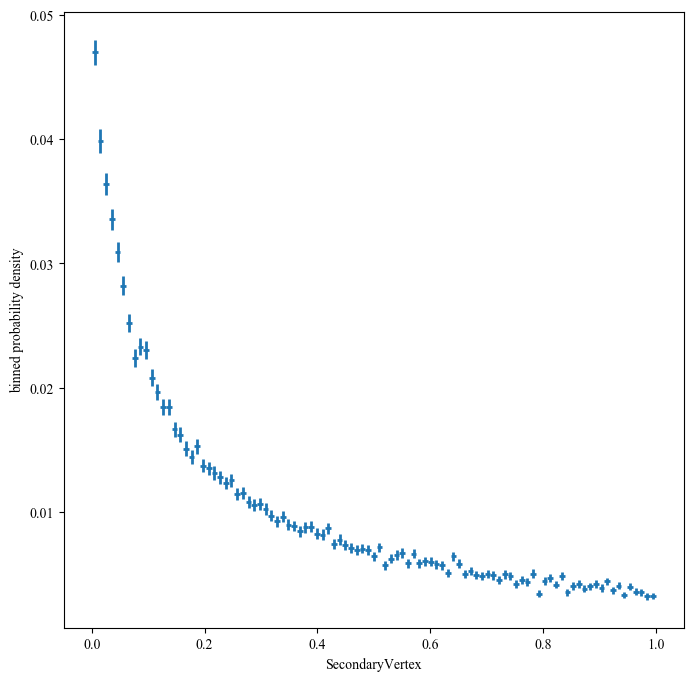

In [215]:
#Testing the secondary vertex displacement variation check it has been loaded in correctly.
binneddensity(Secondary_Displacement, fixedbinning(0,1,100), xlabel = "SecondaryVertex")

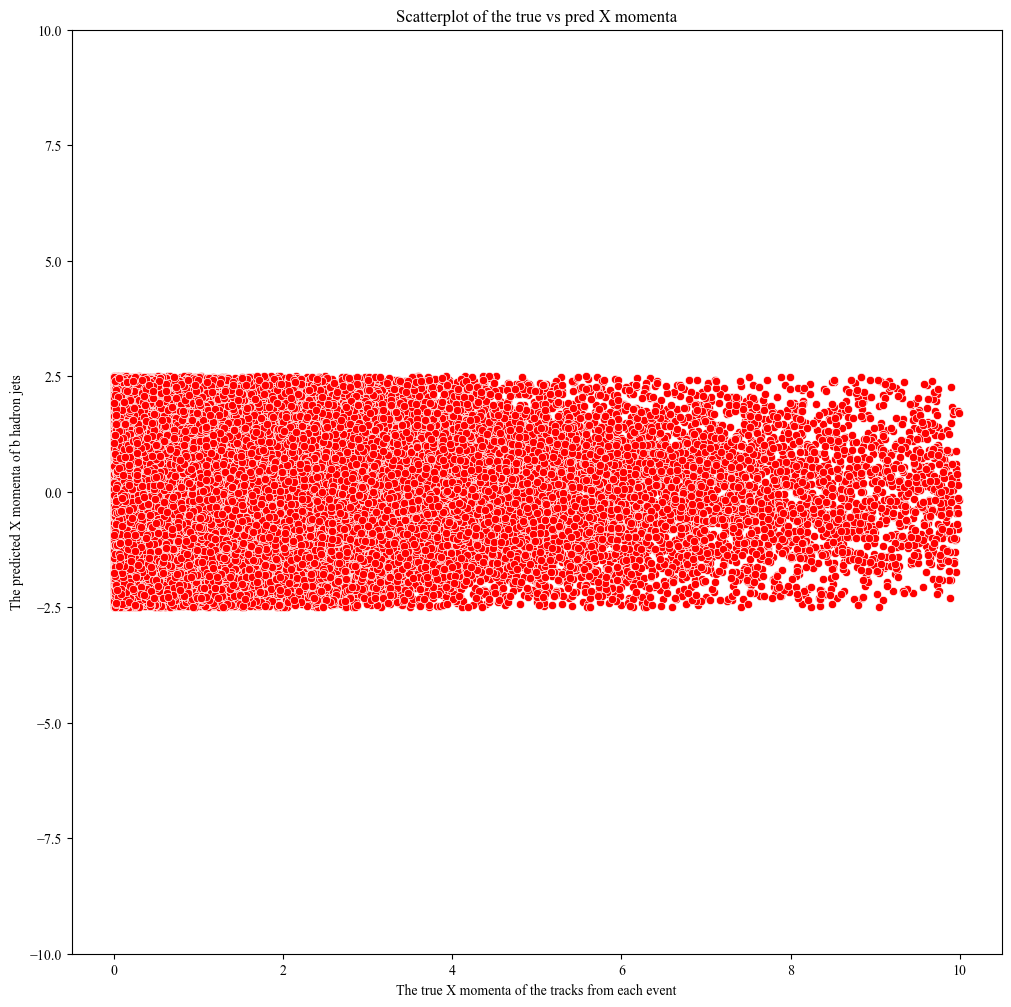

In [219]:
#Testing to see whether any linear correlation exists between the track features and secondary displacement vertex
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = tracks[:,1,4],
    x = Secondary_Displacement,
    color = "red"
)
ax.set_ylim(-10,10)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

In [220]:
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores")
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [222]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature

b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_tracks = np.sum(tracks[:,:,0], axis = 1)
sum_py_tracks = np.sum(tracks[:,:,1], axis = 1)
sum_pz_tracks = np.sum(tracks[:,:,2], axis = 1)
sum_pt_tracks = np.sum(tracks[:,:,3], axis = 1)
print(sum_pt_tracks.shape)

sum_px_tracks_RSE = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1))
sum_py_tracks_RSE= np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1))
sum_pz_tracks_RSE = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1))
sum_pt_tracks_RSE = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1))
print(sum_pt_tracks_RSE.shape)

RSM_scaled_px = sum_px_tracks_RSE/sum_px_tracks
RSM_scaled_py = sum_py_tracks_RSE/sum_py_tracks
RSM_scaled_pz = sum_pz_tracks_RSE/sum_pz_tracks
RSM_scaled_pt = sum_pt_tracks_RSE/sum_pt_tracks
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_tracks = np.log(abs(tracks[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_tracks = np.log(abs(tracks[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_tracks = np.log(abs(tracks[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_tracks = np.log(abs(tracks[:,:,3]/b_jets[:,np.newaxis,3]))
Log_tracks = np.stack([Log_px_tracks, Log_py_tracks, Log_pz_tracks, Log_pt_tracks], axis = -1)

Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

tracks_fractions_px = tracks[:,:,0]/b_jets[:,np.newaxis,0]
tracks_fractions_py = tracks[:,:,1]/b_jets[:,np.newaxis,1]
tracks_fractions_pz = tracks[:,:,2]/b_jets[:,np.newaxis,2]
tracks_fractions_pt = tracks[:,:,3]/b_jets[:,np.newaxis,3]
print(tracks_fractions_pt.shape)
Track_fractions = np.stack([tracks_fractions_px,tracks_fractions_py, tracks_fractions_pz], axis = -1)
print(Track_fractions.shape)

print(Track_fractions.shape)
print(tracks[0,0,0]/b_jets[0,0])
print(np.mean(Track_fractions),np.std(Track_fractions))

print("hey")
Tracks_projection = ((tracks[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(Tracks_projection.shape)
Track_Momenta = np.stack([sum_px_tracks, sum_py_tracks, sum_pz_tracks], axis = -1)
print(Track_Momenta.shape)
Sum_Tracks_projection = ((Track_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_Tracks_projection.shape)

b_jet_energy_ratio_px = sum_px_tracks/b_jets_energy
b_jet_energy_ratio_py = sum_py_tracks/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_tracks/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_tracks/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
print("end")
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))

b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_tracks, sum_py_tracks, sum_pz_tracks, sum_pt_tracks, sum_px_tracks_RSE, sum_py_tracks_RSE, sum_pz_tracks_RSE, sum_pt_tracks_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0],bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy, bhads_transverse_mass, bhads_energy_mass_ratio, bhads_projection, bhads_m, Secondary_Displacement], axis = -1)

(72387,)
(72387,) (72387, 1)
(72387,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
0.00039231462406675546 1.4998550456430604
Hello
(72387,)
(72387,)
(72387,)
(72387,)


/tmp/ipykernel_6548/2876407049.py:63: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_6548/2876407049.py:63: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_6548/2876407049.py:64: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_6548/2876407049.py:64: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_6548/2876407049.py:65: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_6548/2876407049.py:65: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_6548/2876407049.py:66: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])


(72387,)
(72387, 32)
(72387, 32, 3)
(72387, 32, 3)
0.14894195156291137
-672.1793639128624 468.7226007441736
hey
(72387, 32)
(72387, 3)
(72387,)
(72387,)
(72387,)
79564.74
()
(72387,)
(72387,)
end
216667.11 189988.62


In [223]:
#Masking out the padding added to some of the bhadron targets
bhads_targets = np.ma.masked_values(bhads_targets, -999)

In [224]:
np.min(bhads_targets[:,-1]), np.max(bhads_targets[:,-1])

(1.4691484466311522e-05, 9.994723320007324)

In [225]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
#Combine the features into one array
Tracks_input = np.concatenate([tracks, Track_fractions, Log_tracks], axis = -1)
print(Tracks_input.shape)

(72387, 32, 18)


In [226]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into an array
b_jets_input = np.concatenate([b_jets, Tracks_projection, Sum_Tracks_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(72387, 71)


In [227]:
make_mi_scores(b_jets_input, Secondary_Displacement)

23    0.009945
15    0.009872
1     0.005336
10    0.003811
21    0.003402
        ...   
39    0.000000
41    0.000000
43    0.000000
44    0.000000
35    0.000000
Name: MI Scores, Length: 71, dtype: float64

In [228]:
make_mi_scores(Tracks_input.reshape(len(Tracks_input),-1), Secondary_Displacement)

36     0.007038
104    0.006272
21     0.005834
86     0.005509
52     0.004935
         ...   
208    0.000000
207    0.000000
206    0.000000
205    0.000000
288    0.000000
Name: MI Scores, Length: 576, dtype: float64

In [231]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({-521: 16000, 521: 15843, 511: 14814, -511: 14767, 531: 3620, -531: 3609, -5122: 1472, 5122: 1440, 5132: 212, -5132: 211, 5232: 195, -5232: 191, 5332: 5, -5332: 5, -541: 2, 555: 1})


In [232]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    elif (PGID == 531 or PGID == -531):
        element = 2
    else:
        element = 4
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(72387, 1)
Counter({0.0: 31843, 1.0: 29581, 2.0: 7229, 4.0: 3734})
(72387, 4)


In [233]:
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0)
onehot = np.delete(onehot, mask, axis = 0)  
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(72387, 71)
(72387, 32, 18) (72387, 71) (72387,) (72387, 15)


In [234]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(72387, 32, 18)
(72387, 71)
(72387, 15)
[ 7.44270685e+00 -1.40444140e+02  2.61286343e+02  8.20004244e+04
  1.24846692e-03 -1.50110785e-03  7.80297414e-01  7.79523402e-01
  7.76586584e-01  1.63460777e+05  8.22225672e+04  3.07994447e+01
  7.77314550e-01  5.30770285e+03  1.34144632e+00] [6.49624615e+04 6.47755805e+04 2.01656554e+05 4.11332885e+04
 1.23717061e+00 1.81270774e+00 2.28101337e-01 2.28643187e-01
 2.26331935e-01 1.49633569e+05 4.10322569e+04 2.81845602e+01
 2.18163252e-01 8.91130757e+01 1.86592360e+00]


In [235]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({-521: 16000, 521: 15843, 511: 14814, -511: 14767, 531: 3620, -531: 3609, -5122: 1472, 5122: 1440, 5132: 212, -5132: 211, 5232: 195, -5232: 191, 5332: 5, -5332: 5, -541: 2, 555: 1})


In [236]:
from collections import Counter
counter = Counter(bhads_m_clean)
print(counter)

Counter({5279.580078125: 29581, 5279.169921875: 21911, 5279.25: 9932, 5366.77001953125: 7229, 5619.39990234375: 1800, 5620.2001953125: 1112, 5791.10009765625: 348, 5788.0: 331, 5790.5: 130, 6070.0: 10, 6277.0: 2, 9912.2001953125: 1})


In [237]:
# Builds the deep neural network
track_layers = [16 for x in range(2)]
jet_layers = [256 for x in range(3)]
b_jets_layers = [16 for x in range(2)]

track_layers = [np.shape(Tracks_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.0001)

[18, 16, 16]
4


2023-02-15 10:30:01.864289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-15 10:30:01.864322: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-15 10:30:01.864345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-02-15 10:30:01.866452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [238]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [239]:
#Summarises the DeepSetsProjector Set Neural Network Architecture
DeepSetProjector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 dense (Dense)                  (None, None, 18)     342         ['input_3[0][0]']                
                                                                                                  
 time_distributed_residual_unit  (None, None, 18)    720         ['dense[1][0]']                  
 s (TimeDistributedResidualUnit                                                                   
 s)                                                                                               
                                                                                              

In [241]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [242]:
history  = DeepSetProjector.fit(
    (Tracks_input_scaled,b_jets_input_scaled), y = {"MultivariateLoss":Standardized_Bhads_targets, "MassOutput":onehot},
    validation_split = 0.3,
    epochs = EPOCHS,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/1000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
792/792 [==============================] - 24s 19ms/step - loss: 53.5355 - MultivariateLoss_loss: 23.0068 - MassOutput_loss: 1.1956 - MultivariateLoss_Mean_Squared_Error: 0.9903 - MassOutput_Mean_Squared_Error: 0.1659 - val_loss: 44.0441 - val_MultivariateLoss_loss: 15.7992 - val_MassOutput_loss: 1.1458 - val_MultivariateLoss_Mean_Squared_Error: 0.7341 - val_MassOutput_Mean_Squared_Error: 0.1604 - lr: 1.0000e-04
Epoch 2/1000
792/792 [==============================] - 14s 18ms/step - loss: 40.4735 - MultivariateLoss_loss: 13.5149 - MassOutput_loss: 1.1335 - MultivariateLoss_Mean_Squared_Error: 0.6504 - MassOutput_Mean_Squared_Error: 0.1592 - val_loss: 37.8075 - val_MultivariateLoss_loss: 11.8839 - val_MassOutput_loss: 

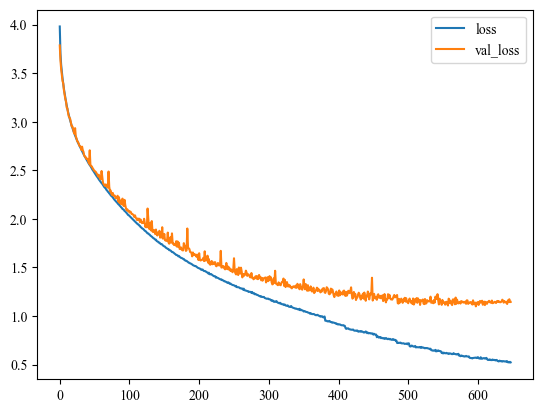

In [289]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [243]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((Tracks_input_scaled,b_jets_input_scaled),(Standardized_Bhads_targets, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

2263/2263 - 8s - loss: 2.1425 - MultivariateLoss_loss: -3.1390e-02 - MassOutput_loss: 1.1028 - MultivariateLoss_Mean_Squared_Error: 0.3496 - MassOutput_Mean_Squared_Error: 0.1559 - 8s/epoch - 4ms/step
The Loaded DeepNet has loss:  [2.142519235610962, -0.031390104442834854, 1.102803349494934, 0.3495764136314392, 0.15592367947101593]


In [244]:
predictions = DeepSetProjector.predict((Tracks_input_scaled, b_jets_input_scaled))

2263/2263 [==============================] - 6s 2ms/step


In [245]:
Predictions = np.stack([DeepSetProjector((Tracks_input_scaled, b_jets_input_scaled))[0] for sample in range(100)])
Predictions = Predictions.mean(axis = 0)

In [246]:
Predictions = predictions[0]
Predictions_Mass = predictions[1]

In [ ]:
Predictions.shape

In [247]:
lister = []
index = 0
predictions_x = Predictions[:,:np.shape(Standardized_Bhads_targets)[1]]
for bhads_features in range(np.shape(predictions_x)[1]):
    Predictions_temp = predictions_x[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds[index]) + means[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_X = np.concatenate(lister, axis = 1)
print(Predictions_X)

[[ 3.7253301e+04  4.0823375e+04 -1.5381233e+05 ...  7.1565199e-01
   5.3031104e+03  1.1167179e+00]
 [ 4.2591934e+04  4.6631903e+02  3.1764215e+04 ...  4.4034252e-01
   5.3057261e+03  9.2671120e-01]
 [ 2.5781434e+04  5.5406090e+04 -5.2291398e+04 ...  9.7697973e-01
   5.2952788e+03  1.4196098e+00]
 ...
 [ 5.7980879e+04  7.5332445e+04  5.7128582e+04 ...  9.5424765e-01
   5.2949932e+03  1.3371272e+00]
 [ 4.4161840e+04 -3.0568330e+04 -3.0070272e+05 ...  5.3737581e-01
   5.3249180e+03  1.3330375e+00]
 [-5.2132859e+04 -4.3500034e+03 -7.5143492e+04 ...  7.4340892e-01
   5.3071675e+03  1.2115767e+00]]


In [248]:
lister = []
index = 0
predictions_x_uncertainty = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:2*np.shape(Standardized_Bhads_targets)[1]]
print(predictions_x_uncertainty)
for bhads_features in range(np.shape(predictions_x_uncertainty)[1]):
    Predictions_temp = predictions_x_uncertainty[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds[index]) + means[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_Uncertainty = np.concatenate(lister, axis = 1)
print(Predictions_Uncertainty)

[[0.14628182 0.1683401  0.19435892 ... 0.82174987 0.9454232  0.84724885]
 [0.18142512 0.01958949 0.05977661 ... 0.5567043  0.8605346  0.8026291 ]
 [0.03838228 0.10427909 0.03237922 ... 0.51347834 0.6278936  0.92768127]
 ...
 [0.16021399 0.202762   0.04362545 ... 0.78015155 0.7731581  1.0040725 ]
 [0.28257173 0.18131007 0.57103485 ... 0.9501179  1.2517929  0.9205814 ]
 [0.22600442 0.04228185 0.09677076 ... 0.91028106 0.9169314  0.81073076]]
[[9.5102695e+03 1.0763884e+04 3.9455031e+04 ... 9.5659018e-01
  5.3919521e+03 2.9223480e+00]
 [1.1793265e+04 1.1284767e+03 1.2315631e+04 ... 8.9876693e-01
  5.3843877e+03 2.8390908e+00]
 [2.5008503e+03 6.6142939e+03 6.7907671e+03 ... 8.8933665e-01
  5.3636562e+03 3.0724287e+00]
 ...
 [1.0415338e+04 1.2993582e+04 9.0586436e+03 ... 9.4751495e-01
  5.3766011e+03 3.2149692e+00]
 [1.8363998e+04 1.1604021e+04 1.1541420e+05 ... 9.8459536e-01
  5.4192539e+03 3.0591807e+00]
 [1.4689246e+04 2.5983875e+03 1.9775744e+04 ... 9.7590441e-01
  5.3894131e+03 2.854208

In [249]:
Error_px_unscaled = bhads_targets_clean[:,0] - Predictions_X[:,0]
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_clean[:,0])
Pull_px = Error_px_unscaled/Predictions_Uncertainty[:,0]

In [250]:
Error_py_unscaled = bhads_targets_clean[:,1] - Predictions_X[:,1]
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_clean[:,1])
Pull_py = Error_py_unscaled/Predictions_Uncertainty[:,1]

In [251]:
Error_pz_unscaled = bhads_targets_clean[:,2] - Predictions_X[:,2]
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_clean[:,2])
Pull_pz = Error_pz_unscaled/Predictions_Uncertainty[:,2]

In [252]:
Error_pt_unscaled = bhads_targets_clean[:,3] - Predictions_X[:,3]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_clean[:,3])
Pull_pt = Error_pt_unscaled/Predictions_Uncertainty[:,3]

In [253]:
Error_eta_unscaled = bhads_targets_clean[:,4] - Predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets_clean[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [254]:
Error_phi_unscaled = bhads_targets_clean[:,5] - Predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_clean[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [255]:
Error_pxfraction_unscaled = bhads_targets_clean[:,6] - Predictions_X[:,6]
Pull_pxfraction_unscaled = Error_pxfraction_unscaled/np.std(bhads_targets_clean[:,6])
Pull_pxfraction = Error_pxfraction_unscaled/Predictions_Uncertainty[:,6]

In [256]:
Error_pyfraction_unscaled = bhads_targets_clean[:,7] - Predictions_X[:,7]
Pull_pyfraction_unscaled = Error_pyfraction_unscaled/np.std(bhads_targets_clean[:,7])
Pull_pyfraction = Error_pyfraction_unscaled/Predictions_Uncertainty[:,7]

In [257]:
Error_pzfraction_unscaled = bhads_targets_clean[:,8] - Predictions_X[:,8]
Pull_pzfraction_unscaled = Error_pzfraction_unscaled/np.std(bhads_targets_clean[:,8])
Pull_pzfraction = Error_pzfraction_unscaled/Predictions_Uncertainty[:,8]

In [258]:
Error_energy_unscaled = bhads_targets_clean[:,9] - Predictions_X[:,9]
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,9])
Pull_energy = Error_energy_unscaled/Predictions_Uncertainty[:,8]

In [259]:
Error_projection_unscaled = bhads_targets_clean[:,12] - Predictions_X[:,12]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_clean[:,12])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,12]

In [260]:
Error_mass_unscaled = bhads_targets_clean[:,13] - Predictions_X[:, 13]
Pull_mass_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,13])
Pull_mass = Error_energy_unscaled/Predictions_Uncertainty[:,13]

In [261]:
Error_Secondary_Displacement_unscaled = bhads_targets_clean[:,14] - Predictions_X[:, 14]
Pull_Secondary_Displacement_unscaled = Error_Secondary_Displacement_unscaled/np.std(bhads_targets_clean[:,14])
Pull_Secondary_Displacement = Error_Secondary_Displacement_unscaled/Predictions_Uncertainty[:,14]

-17.241689540010068
14947.92942499331


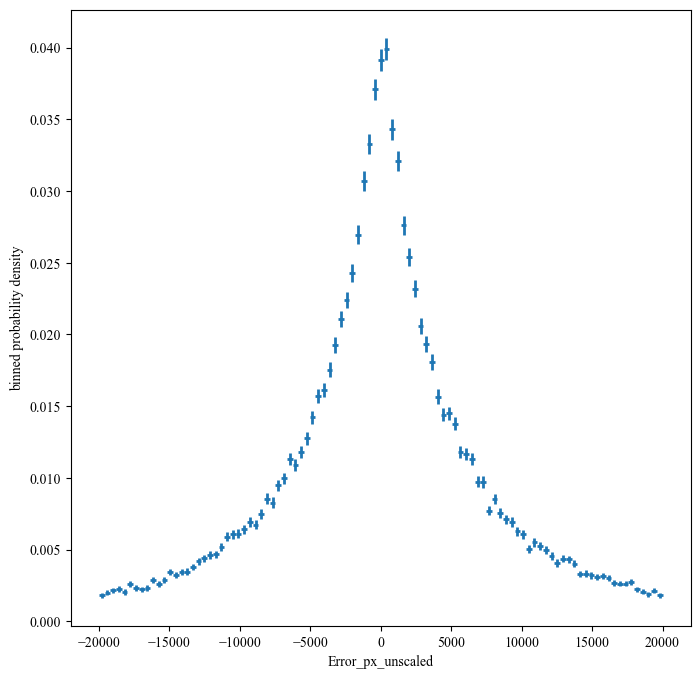

In [262]:
print(np.mean(Error_px_unscaled))
print(np.std(Error_px_unscaled))
binneddensity(Error_px_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_px_unscaled")

0.005274005614368909
0.9624894748620738


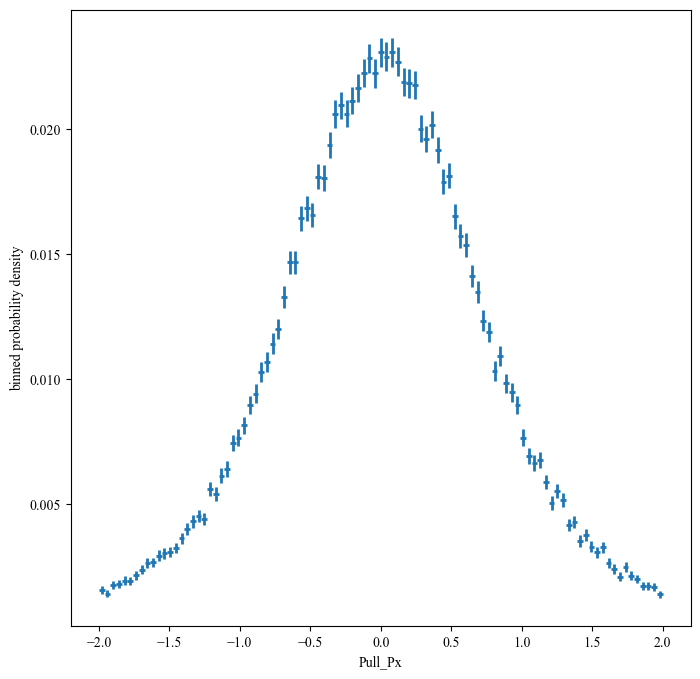

In [263]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-2,2,100),xlabel = "Pull_Px")

-11.908634014974366
14927.08983526812


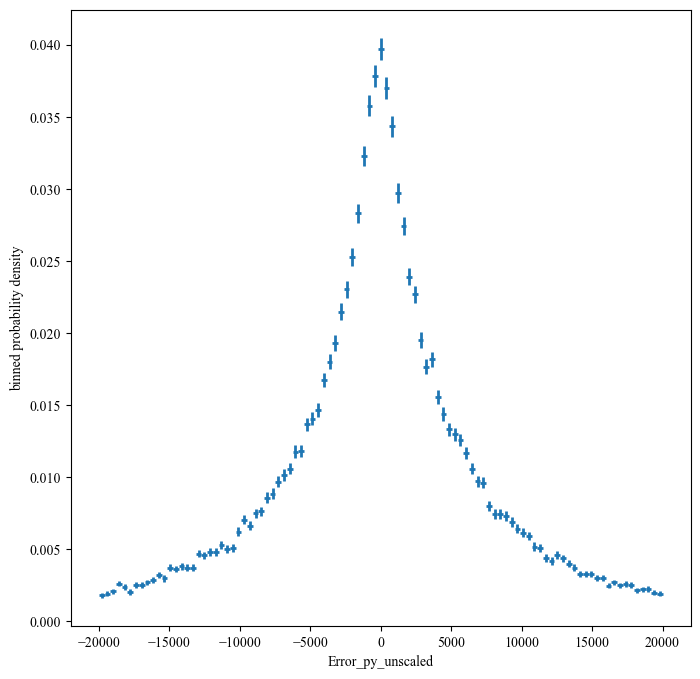

In [264]:
print(np.mean(Error_py_unscaled))
print(np.std(Error_py_unscaled))
binneddensity(Error_py_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_py_unscaled")

-0.012211427974335
0.9936623216875335


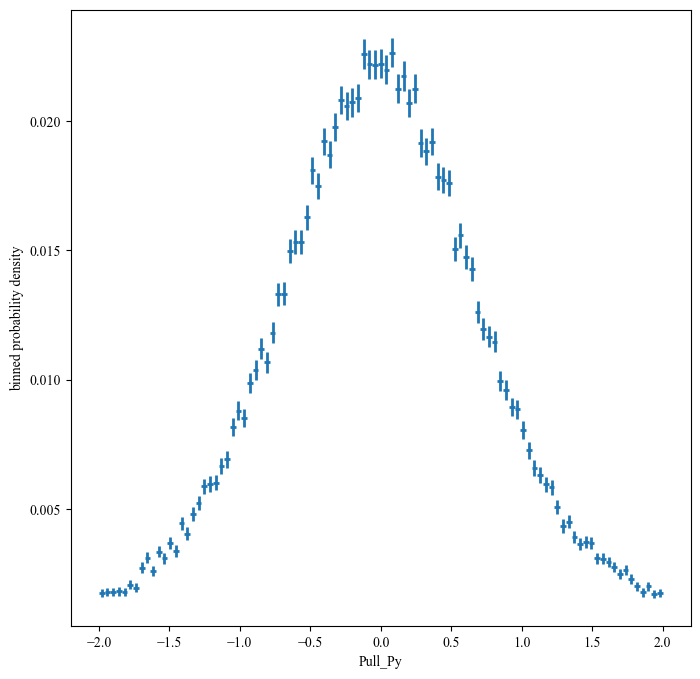

In [265]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-2,2,100),xlabel = "Pull_Py")

-100.62969871094779
48387.79218411711


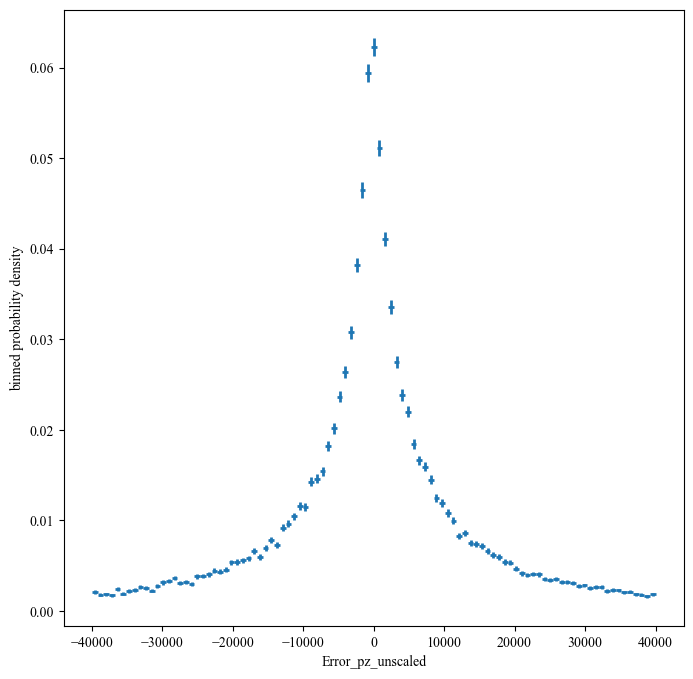

In [266]:
print(np.mean(Error_pz_unscaled))
print(np.std(Error_pz_unscaled))
binneddensity(Error_pz_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pz_unscaled")

-0.03155373953047547
0.9465947599775486


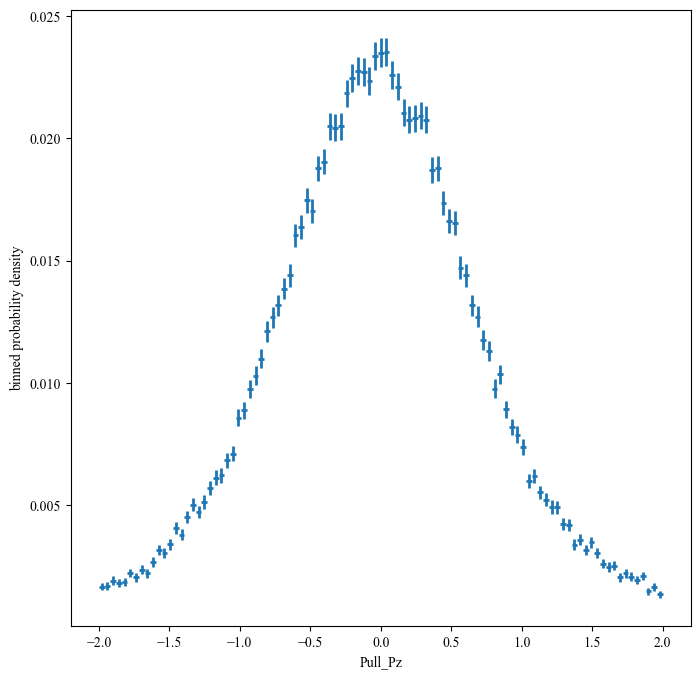

In [267]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-2,2,100),xlabel = "Pull_Pz")

0.0034002160191580113
0.16163502819015257


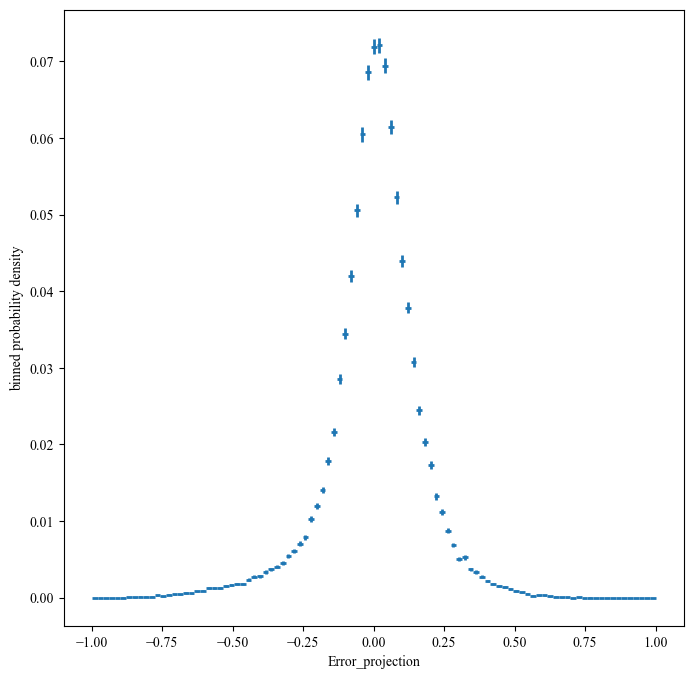

In [268]:
print(np.mean(Error_projection_unscaled))
print(np.std(Error_projection_unscaled))
binneddensity(Error_projection_unscaled, fixedbinning(-1,1,100),xlabel = "Error_projection")

0.0036738567240499715
0.16861768908997646


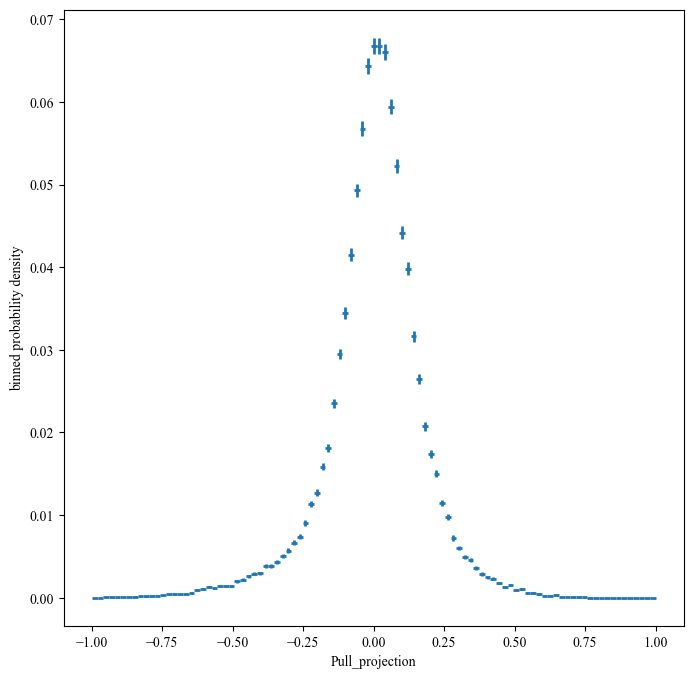

In [269]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-1,1,100),xlabel = "Pull_projection")

0.0030247190417670255
0.1771887928866022


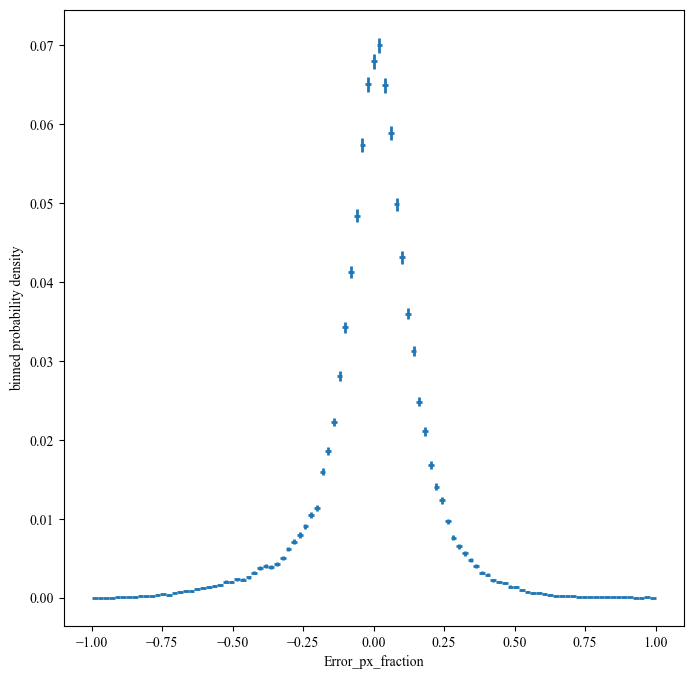

In [270]:
print(np.mean(Error_pxfraction_unscaled))
print(np.std(Error_pxfraction_unscaled))
binneddensity(Error_pxfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_px_fraction")

0.013260417852474534
0.7767985720350703


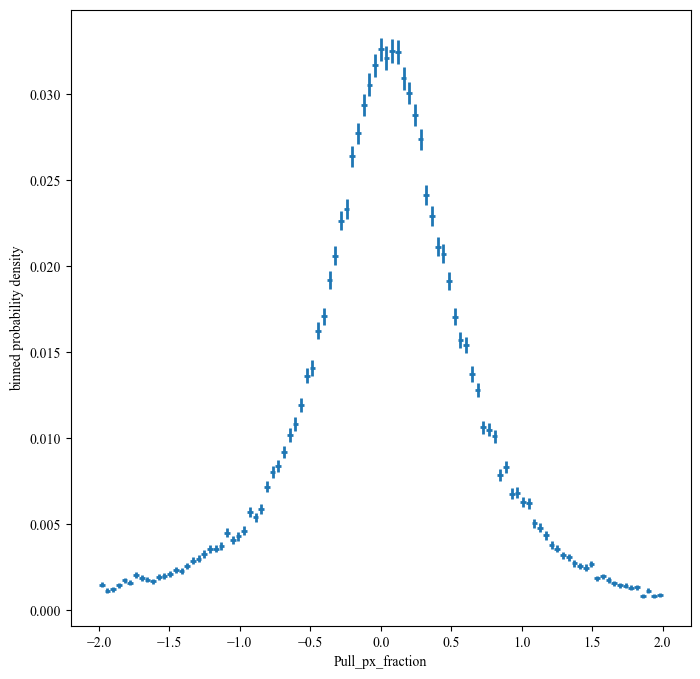

In [271]:
print(np.mean(Pull_pxfraction_unscaled))
print(np.std(Pull_pxfraction_unscaled))
binneddensity(Pull_pxfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_px_fraction")

0.003038868637558214
0.17743318157615012


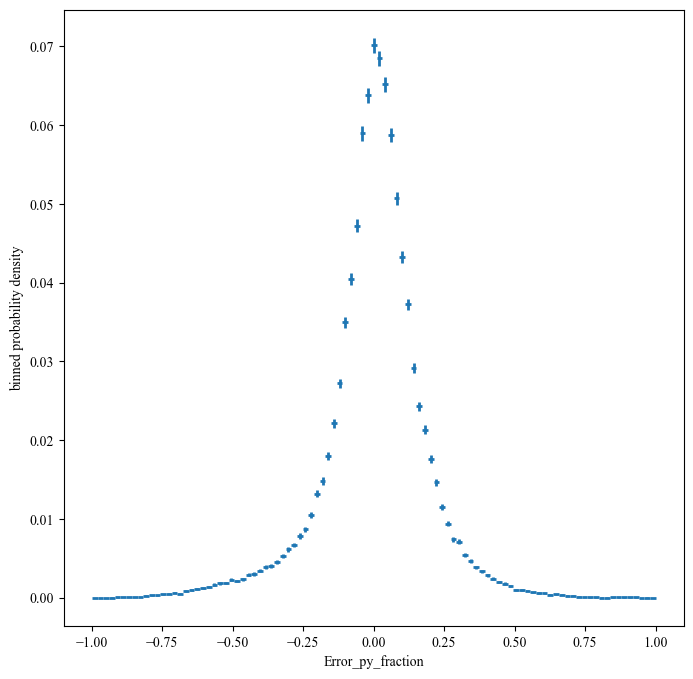

In [272]:
print(np.mean(Error_pyfraction_unscaled))
print(np.std(Error_pyfraction_unscaled))
binneddensity(Error_pyfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_py_fraction")

0.01329087769442352
0.776026540310062


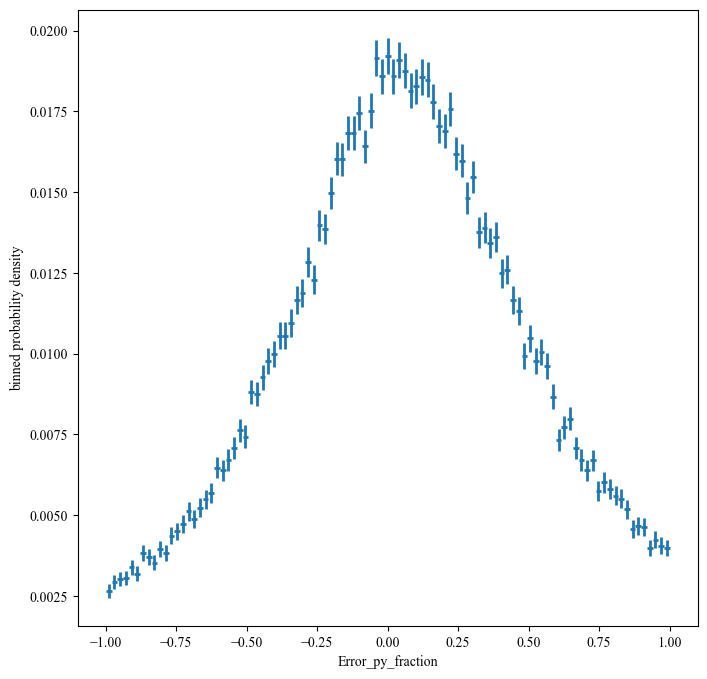

In [273]:
print(np.mean(Pull_pyfraction_unscaled))
print(np.std(Pull_pyfraction_unscaled))
binneddensity(Pull_pyfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_py_fraction")

0.0032921775309648106
0.1748198514517534


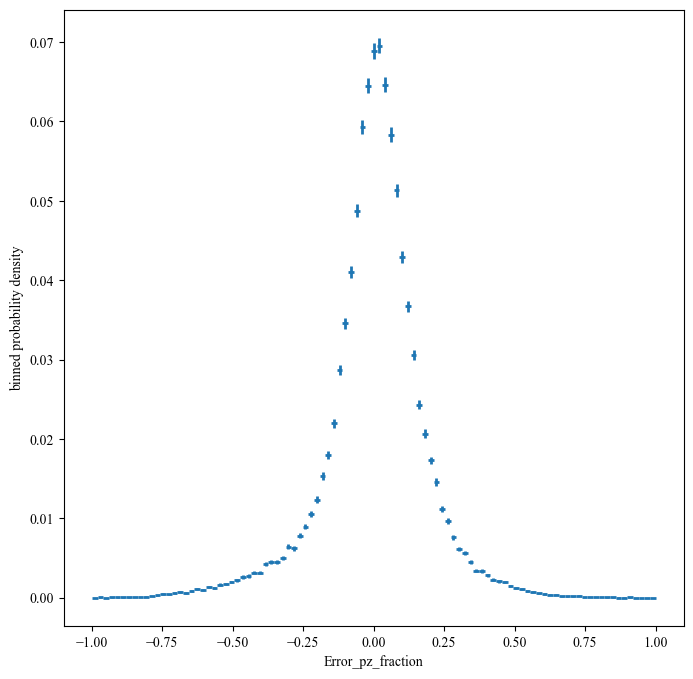

In [274]:
print(np.mean(Error_pzfraction_unscaled))
print(np.std(Error_pzfraction_unscaled))
binneddensity(Error_pzfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_pz_fraction")

0.014545793234515353
0.7724047043601167


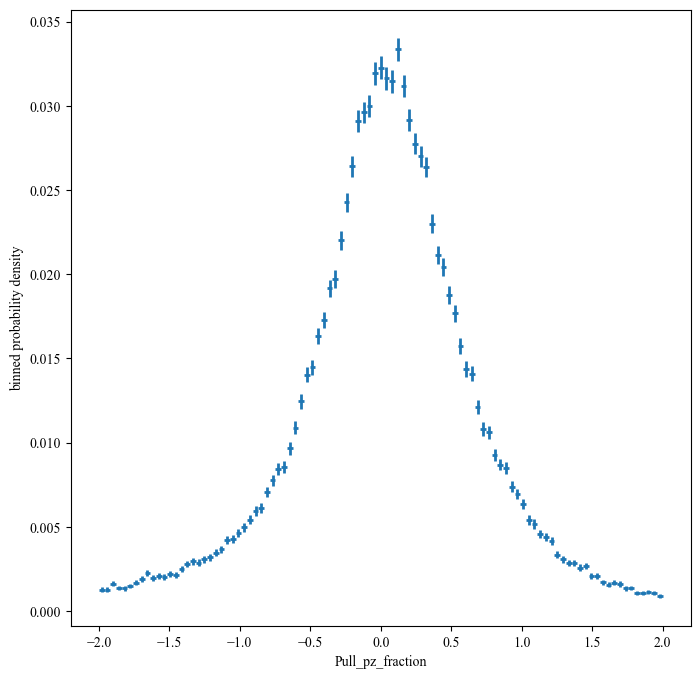

In [275]:
print(np.mean(Pull_pzfraction_unscaled))
print(np.std(Pull_pzfraction_unscaled))
binneddensity(Pull_pzfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_pz_fraction")

1825.5464370865025
50831.10405165343


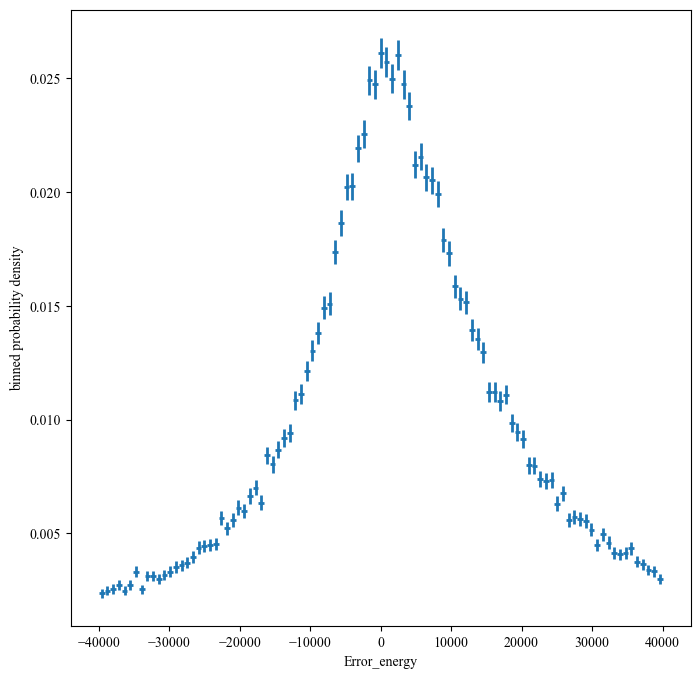

In [276]:
print(np.mean(Error_energy_unscaled))
print(np.std(Error_energy_unscaled))
binneddensity(Error_energy_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_energy")

0.01220011293458847
0.3397038812169116


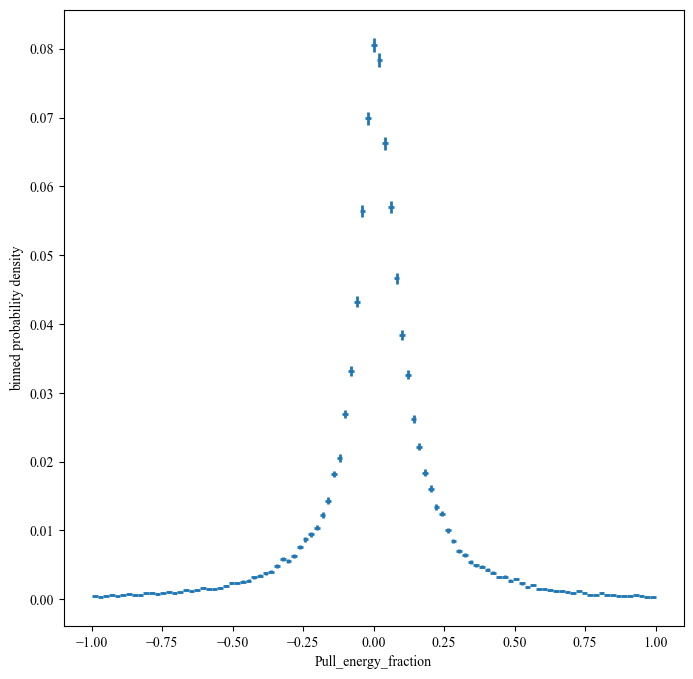

In [277]:
print(np.mean(Pull_energy_unscaled))
print(np.std(Pull_energy_unscaled))
binneddensity(Pull_energy_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_energy_fraction")

1.2034048610355623
88.82954199477032


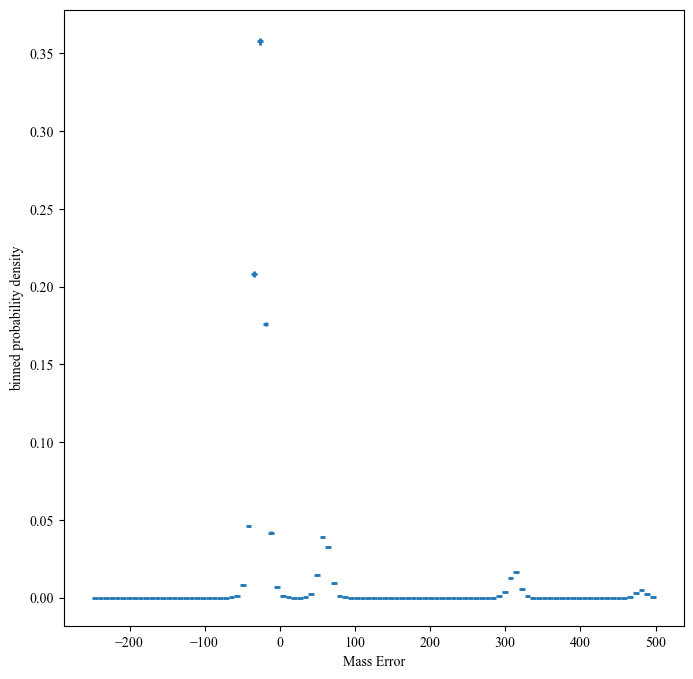

In [278]:
print(np.mean(Error_mass_unscaled))
print(np.std(Error_mass_unscaled))
binneddensity(Error_mass_unscaled, fixedbinning(-250,500,100),xlabel = "Mass Error")

445.2180744117232
20796.33209393915


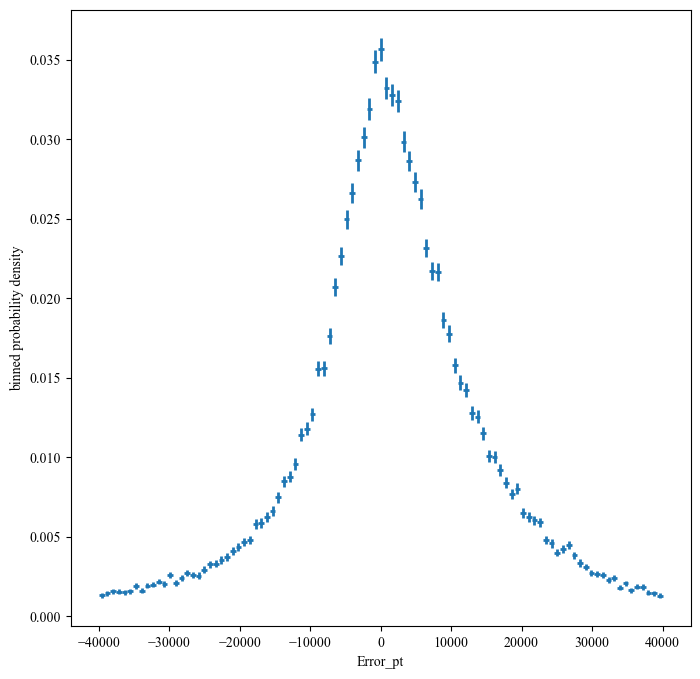

In [279]:
print(np.mean(Error_pt_unscaled))
print(np.std(Error_pt_unscaled))
binneddensity(Error_pt_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pt")

0.004121839492227756
0.18095244843955116


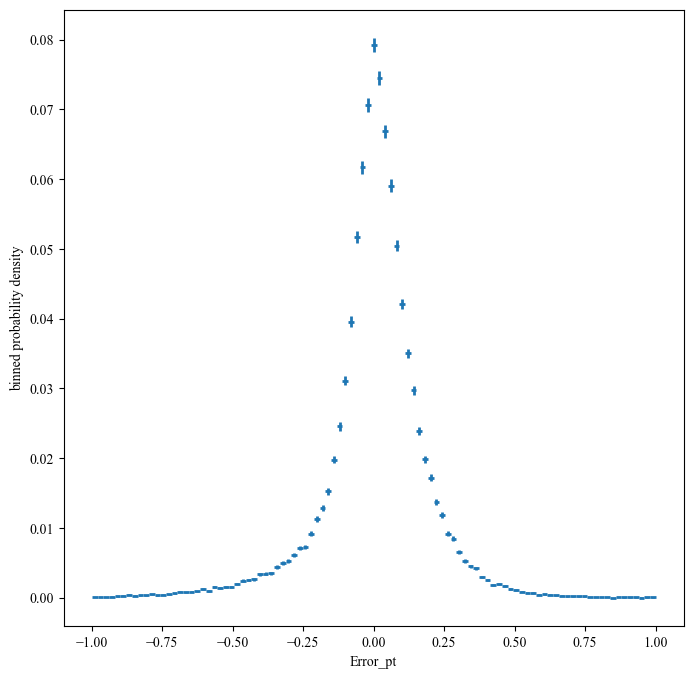

In [280]:
print(np.mean(Pull_pt))
print(np.std(Pull_pt))
binneddensity(Pull_pt, fixedbinning(-1,1,100),xlabel = "Error_pt")

-0.000650677508329889
0.054660263467448345


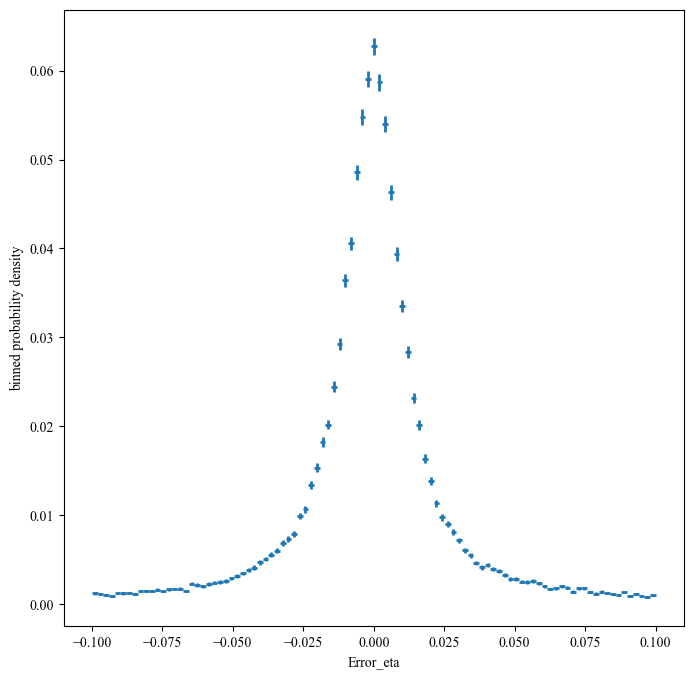

In [281]:
print(np.mean(Error_eta_unscaled))
print(np.std(Error_eta_unscaled))
binneddensity(Error_eta_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_eta")

-0.015578923666908195
0.9585943016087953


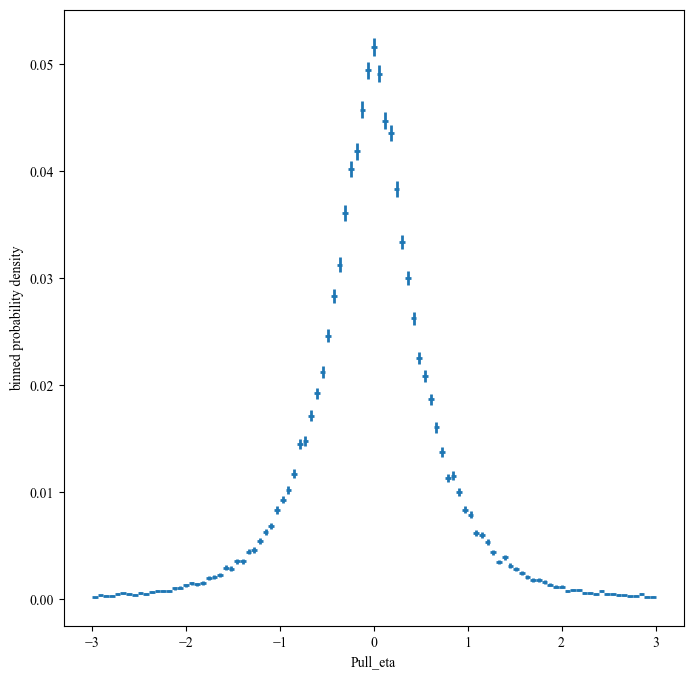

In [282]:
print(np.mean(Pull_eta))
print(np.std(Pull_eta))
binneddensity(Pull_eta, fixedbinning(-3,3,100),xlabel = "Pull_eta")

0.001479131629832602
0.0571955614497127


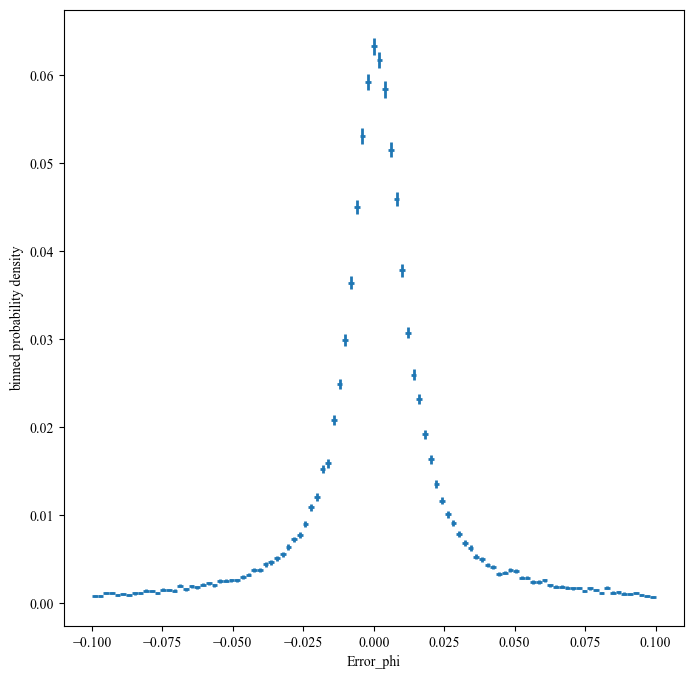

In [283]:
print(np.mean(Error_phi_unscaled))
print(np.std(Error_phi_unscaled))
binneddensity(Error_phi_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_phi")

0.06283868435641887
1.0342020733485373


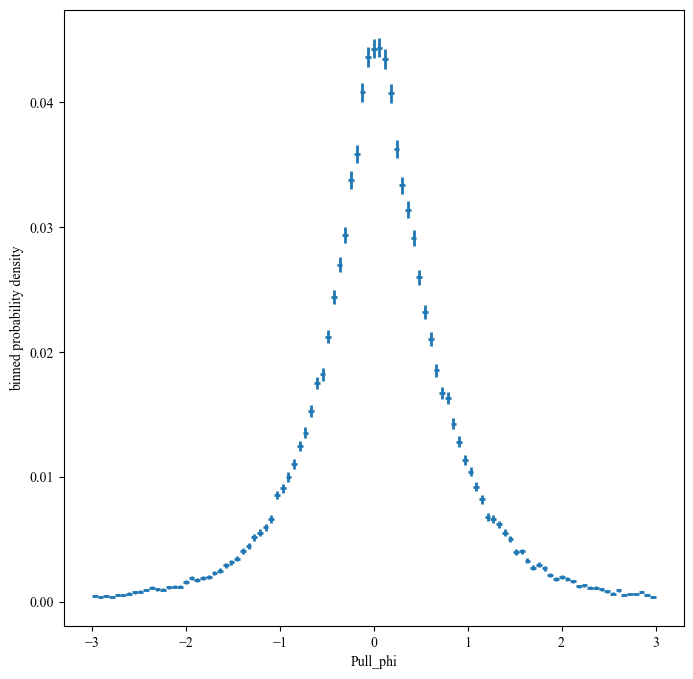

In [284]:
print(np.mean(Pull_phi))
print(np.std(Pull_phi))
binneddensity(Pull_phi, fixedbinning(-3,3,100),xlabel = "Pull_phi")

-0.7587717771530151
1.8564723501397167


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


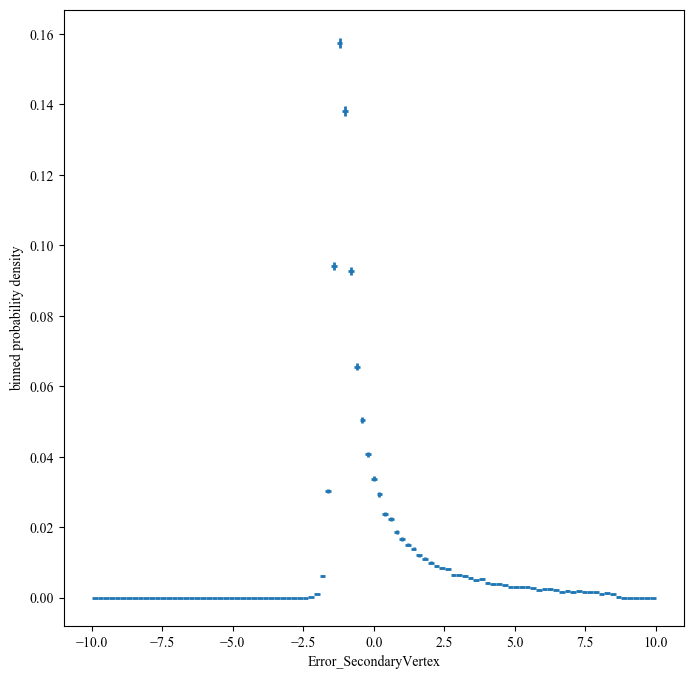

In [285]:
print(np.median(Error_Secondary_Displacement_unscaled))
print(np.std(Error_Secondary_Displacement_unscaled))
binneddensity(Error_Secondary_Displacement_unscaled, fixedbinning(-10,10,100),xlabel = "Error_SecondaryVertex")

-0.24390834326138106
0.5755718334727971


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


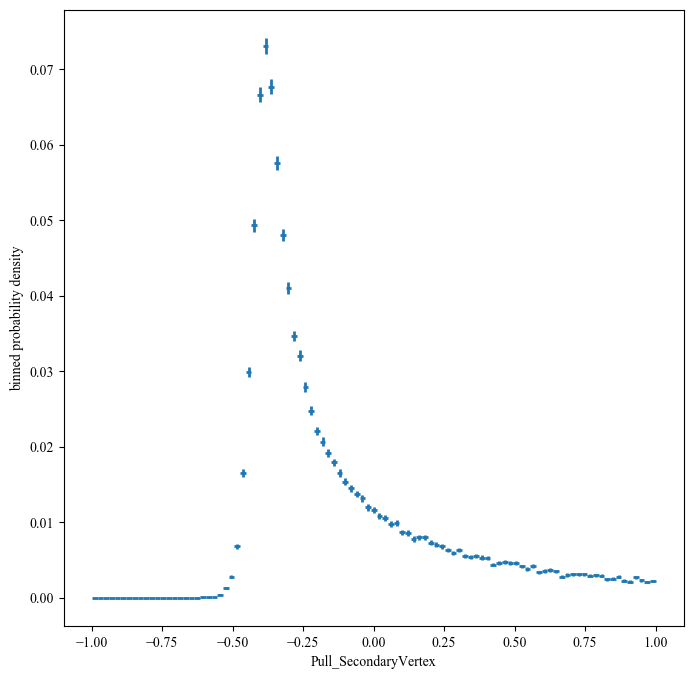

In [287]:
print(np.median(Pull_Secondary_Displacement))
print(np.std(Pull_Secondary_Displacement))
binneddensity(Pull_Secondary_Displacement, fixedbinning(-1,1,100),xlabel = "Pull_SecondaryVertex")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X momenta of b hadron jets')

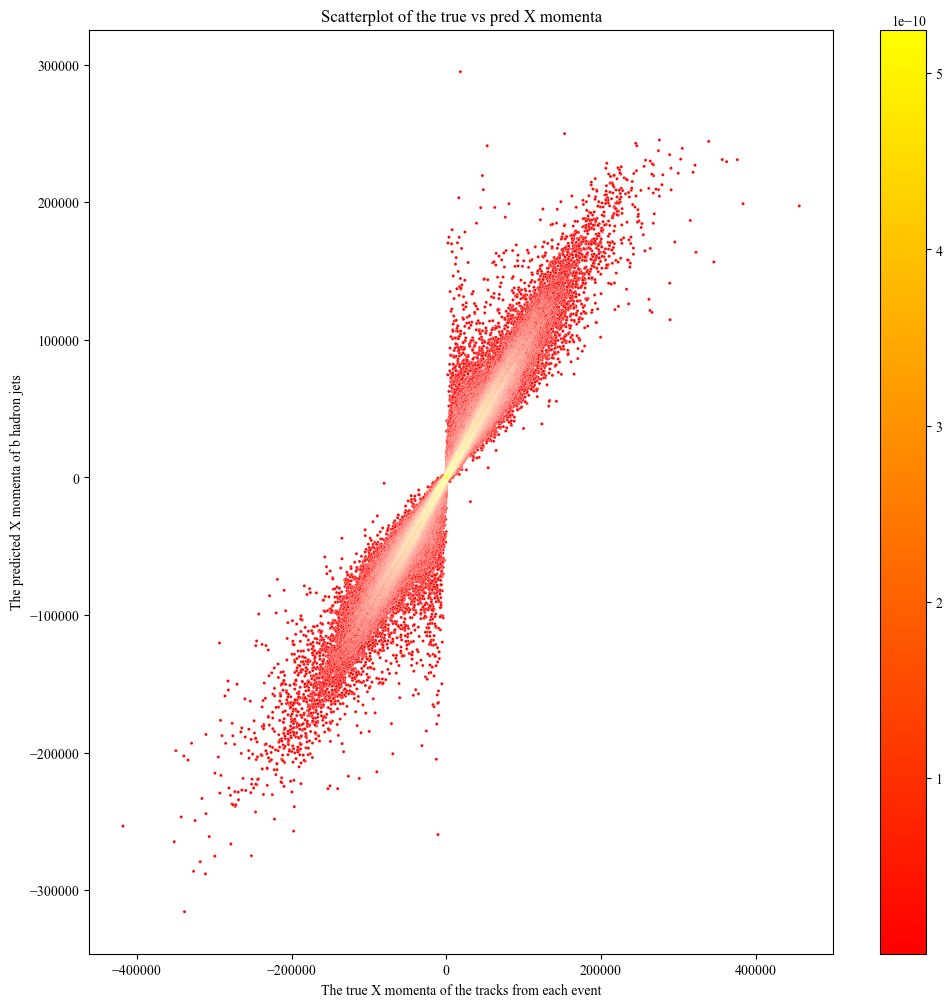

In [290]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,0]
y = Predictions_X[:,0]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [ ]:
[bhads[:,0],bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy, bhads_transverse_mass, bhads_energy_mass_ratio, bhads_projection, bhads_m, Secondary_Displacement]

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

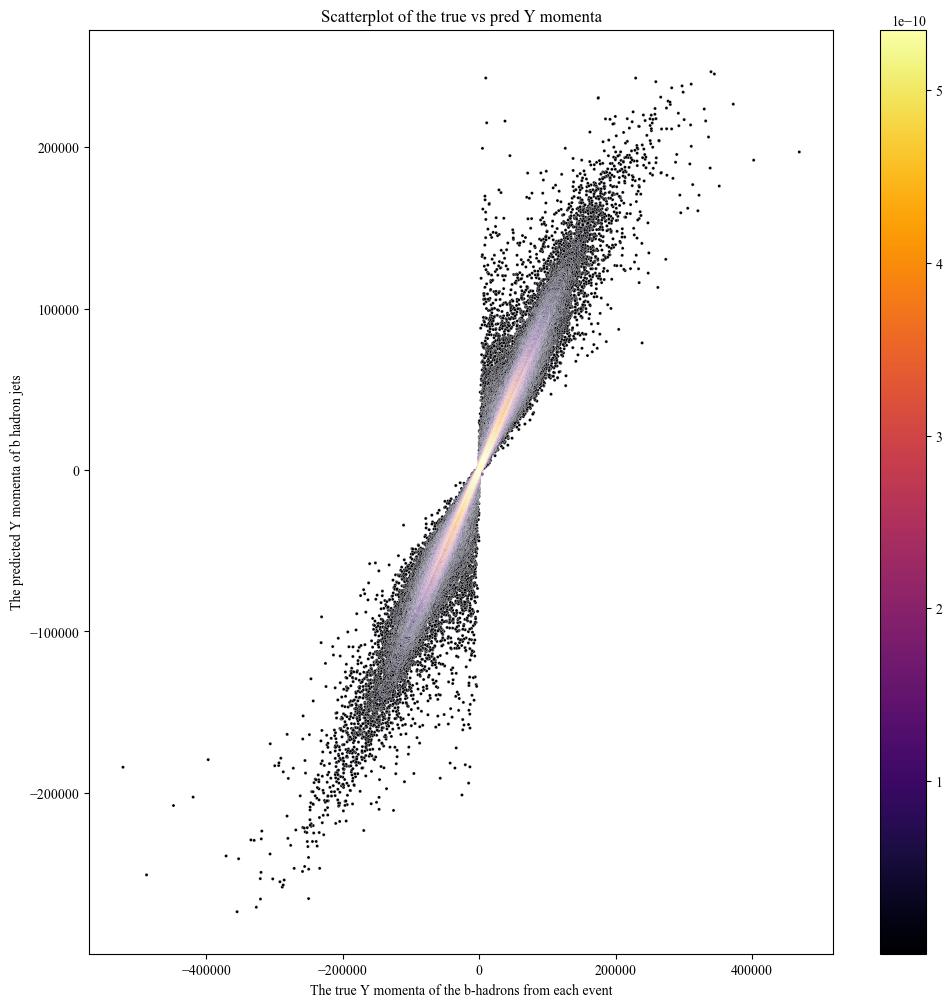

In [291]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,1]
y = Predictions_X[:,1]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

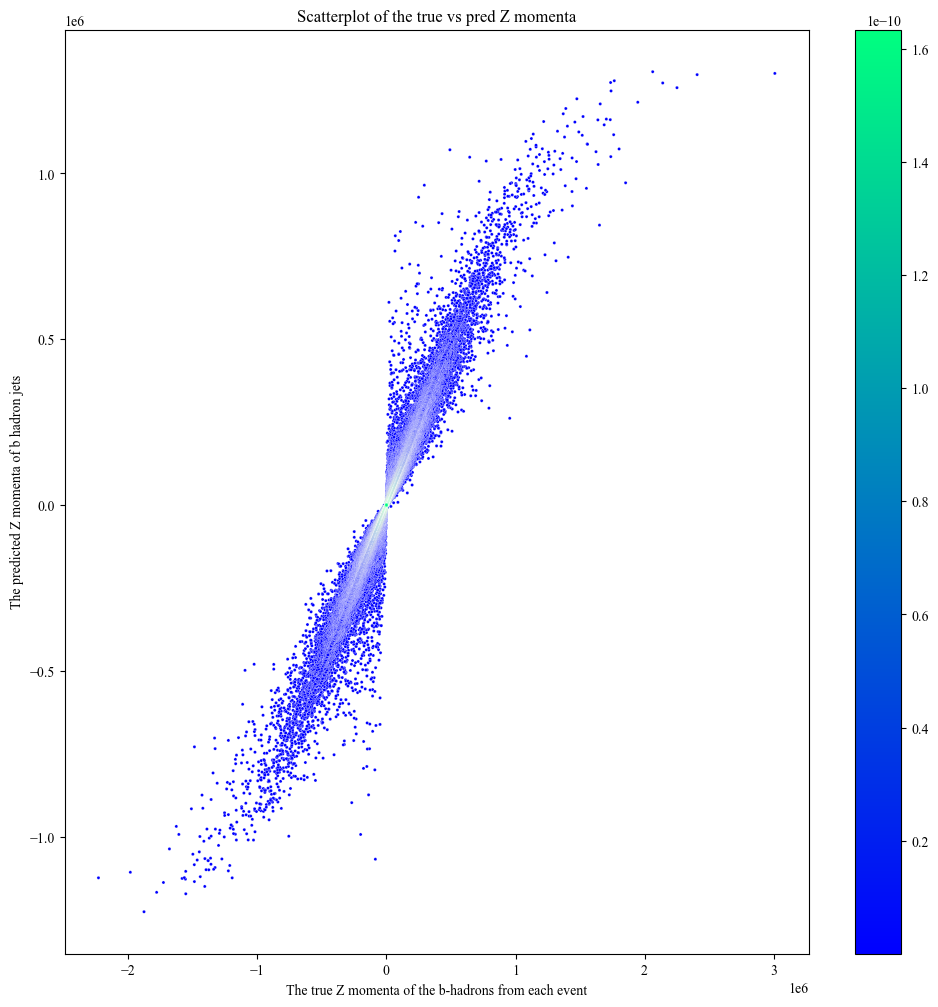

In [292]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,2]
y = Predictions_X[:,2]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted transverse momenta of b hadron jets')

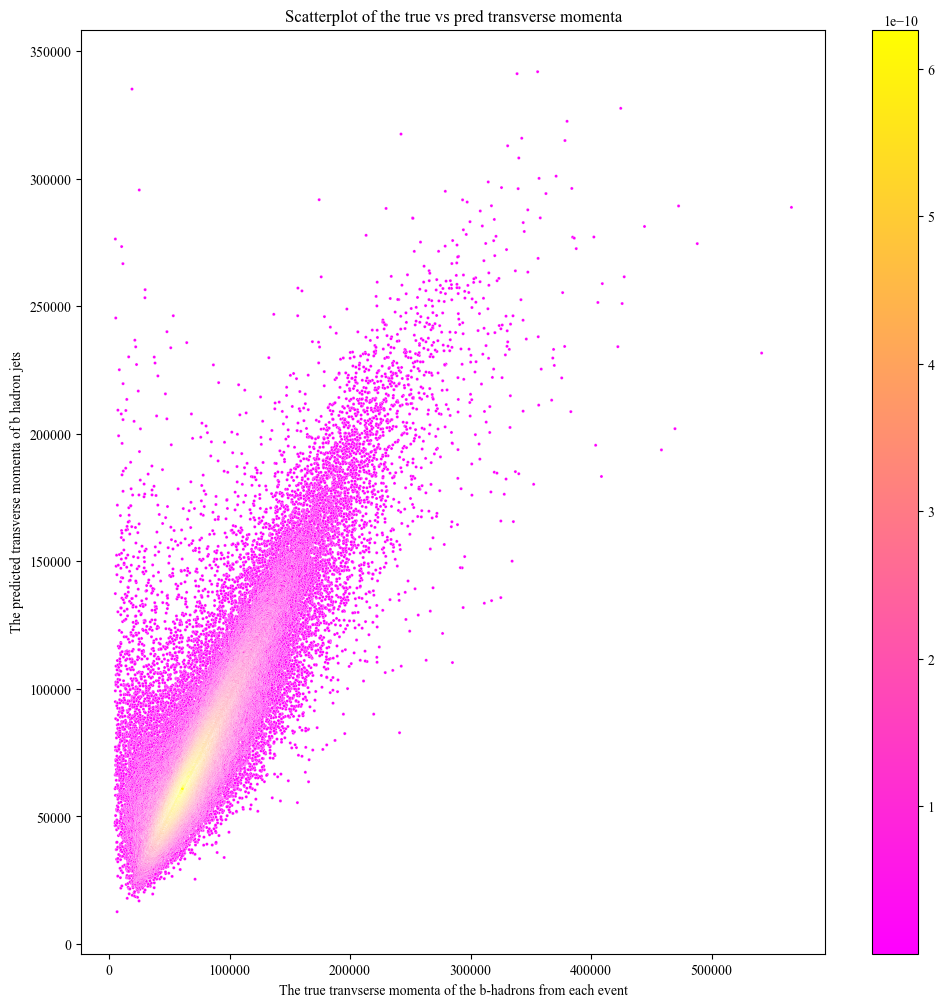

In [293]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,3]
y = Predictions_X[:,3]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred transverse momenta")
ax.set_xlabel("The true tranvserse momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted transverse momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted pseudorapidity of b hadron jets')

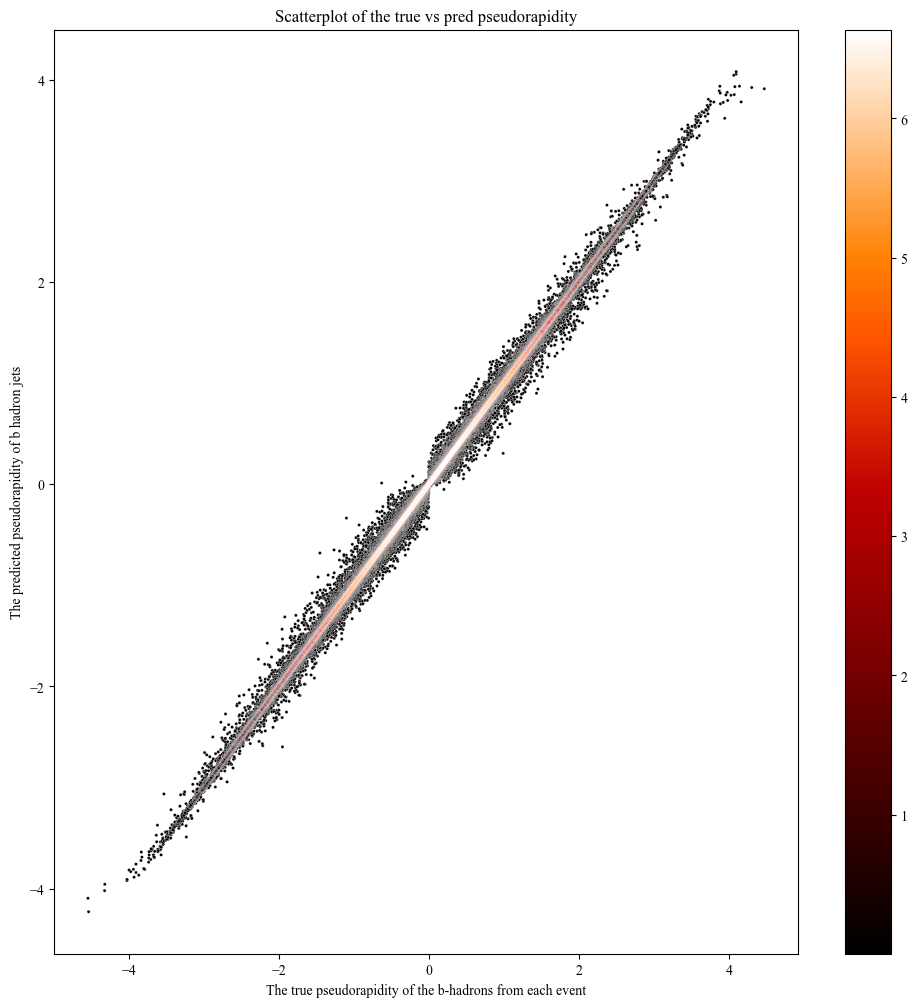

In [294]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,4]
y = Predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred pseudorapidity")
ax.set_xlabel("The true pseudorapidity of the b-hadrons from each event")
ax.set_ylabel("The predicted pseudorapidity of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted phi of b hadron jets')

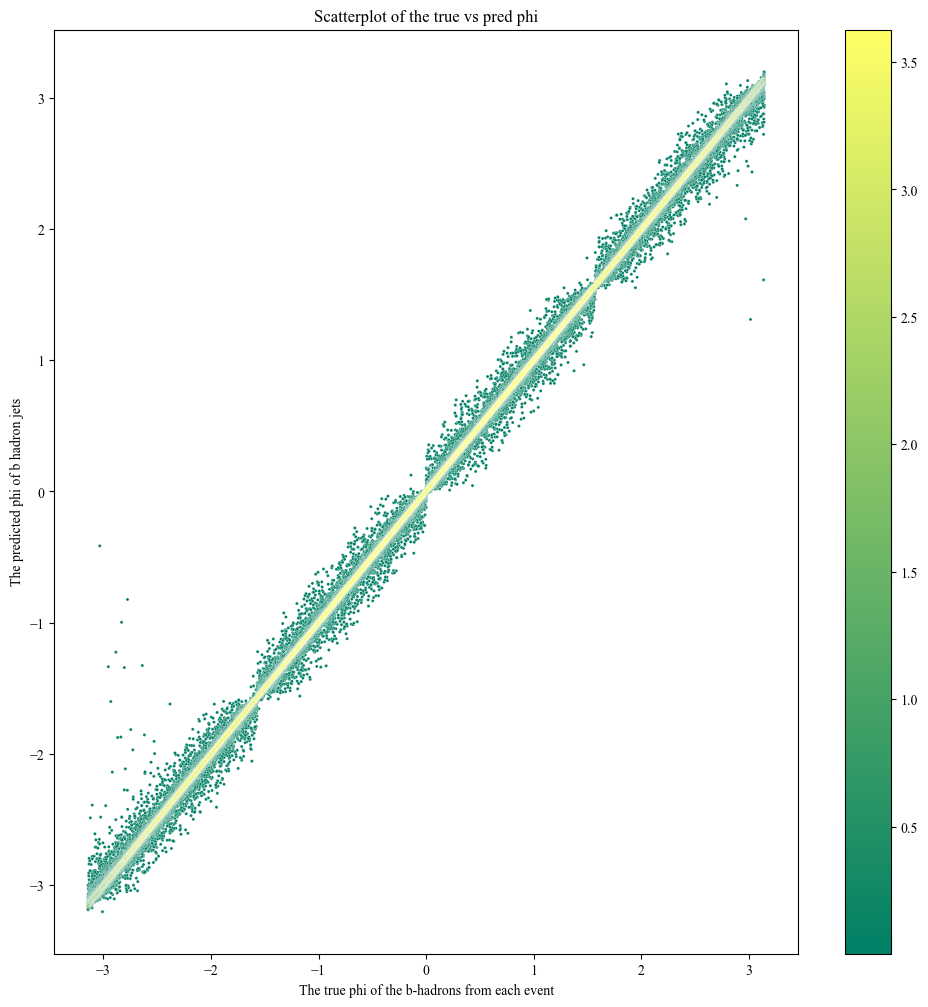

In [295]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,5]
y = Predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred phi")
ax.set_xlabel("The true phi of the b-hadrons from each event")
ax.set_ylabel("The predicted phi of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X fraction of b hadron jets')

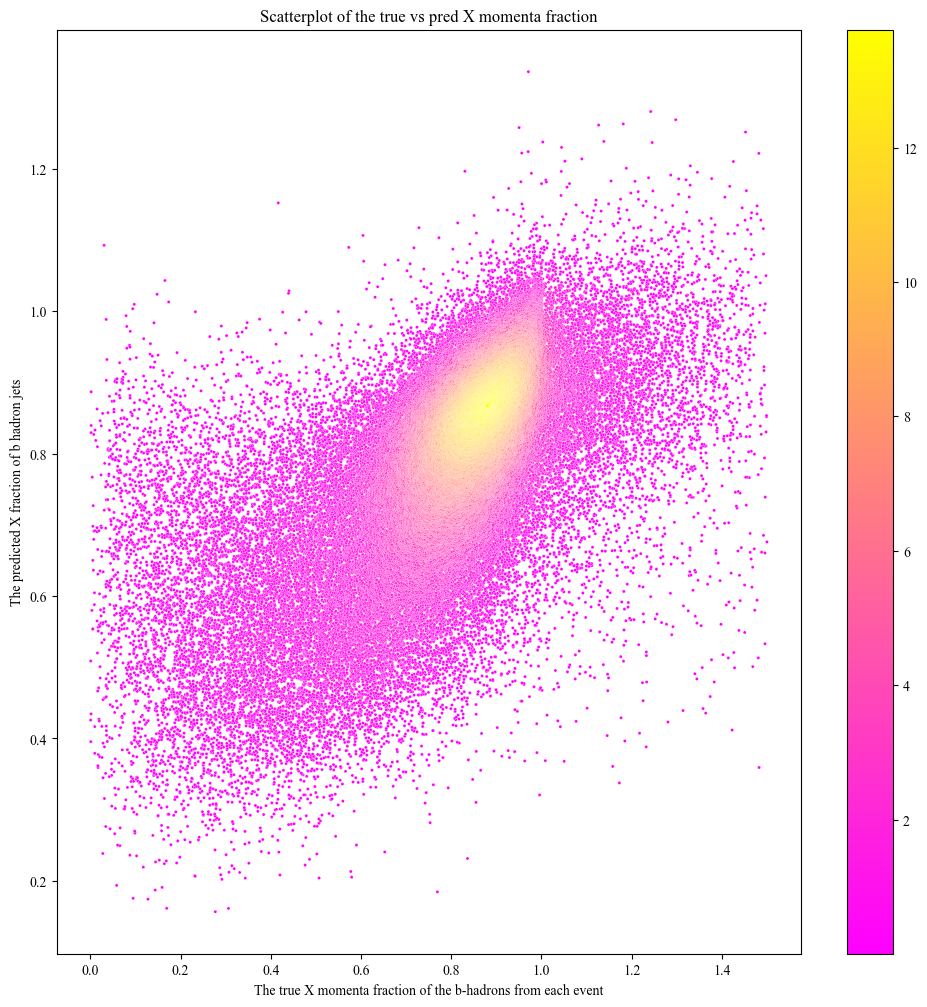

In [296]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,6]
y = Predictions_X[:,6]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta fraction")
ax.set_xlabel("The true X momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted X fraction of b hadron jets")

KeyboardInterrupt: 

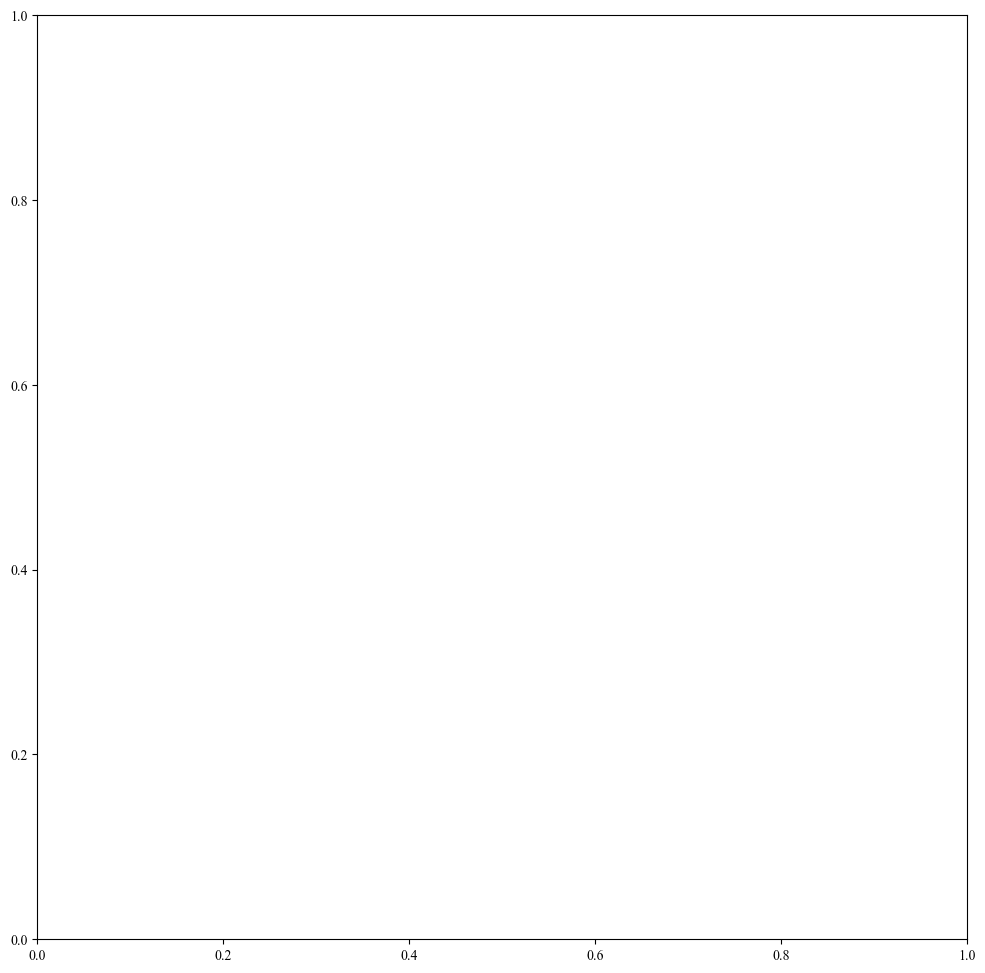

In [297]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,7]
y = Predictions_X[:,7]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta fraction")
ax.set_xlabel("The true Y momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted Y fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,8]
y = Predictions_X[:,8]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta fraction")
ax.set_xlabel("The true Z momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted Z fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,9]
y = Predictions_X[:,9]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron energy")
ax.set_xlabel("The true Bhadron energy of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron energy of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,12]
y = Predictions_X[:,12]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron projection")
ax.set_xlabel("The true Bhadron projection of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron projection of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,13]
y = Predictions_X[:,13]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron mass")
ax.set_xlabel("The true Bhadron mass of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron mass of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,14]
y = Predictions_X[:,14]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron Secondary Vertex Displacement")
ax.set_xlabel("The true Bhadron Secondary Vertex Displacement of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron Secondary Vertex Displacement of b hadron jets")

Text(0, 0.5, 'The predicted X momenta of b hadron jets')

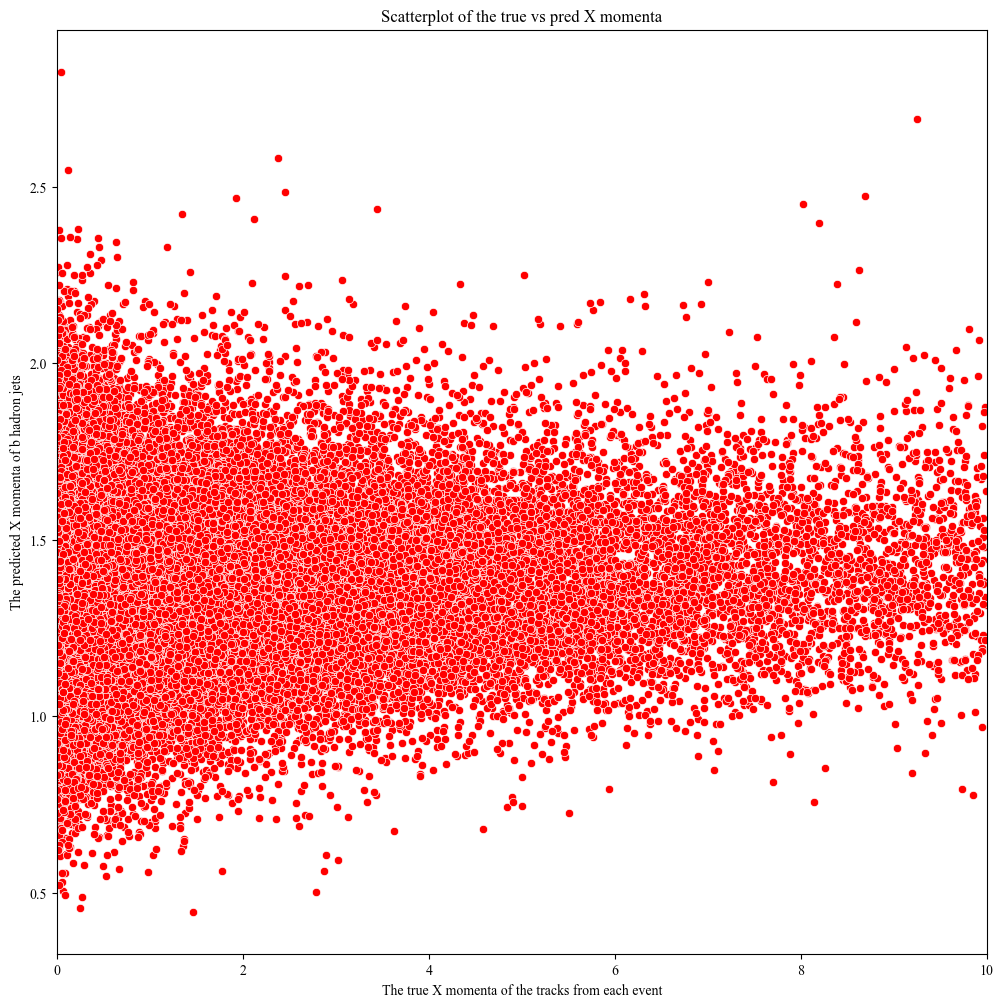

In [313]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_X[:,14],
    x = bhads_targets_clean[:,14],
    color = "red"
)
ax.set_xlim(0,10)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [309]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1)))

              precision    recall  f1-score   support

           0       0.46      0.69      0.55     31843
           1       0.44      0.36      0.39     29581
           2       0.00      0.00      0.00      7229
           3       0.00      0.00      0.00      3734

    accuracy                           0.45     72387
   macro avg       0.22      0.26      0.24     72387
weighted avg       0.38      0.45      0.40     72387



/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

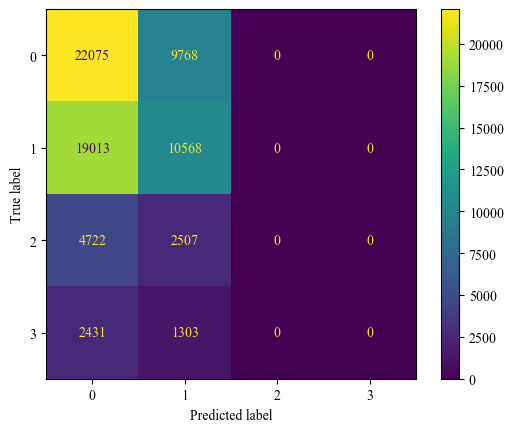

In [310]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1))
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [ ]:
print(Predictions_X[:10,13])
print(bhads_targets_clean[:10,13])

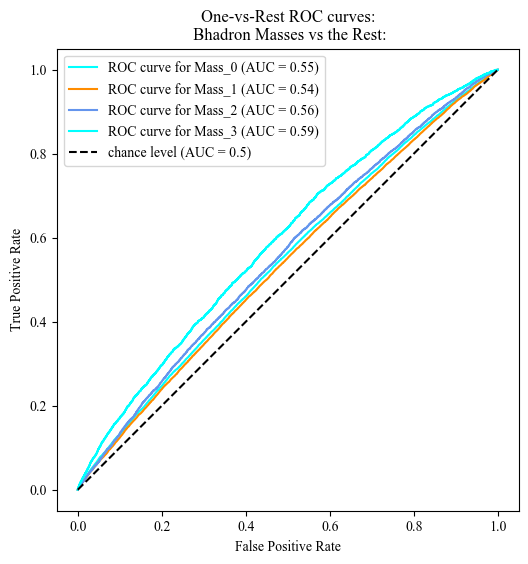

In [312]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5"]
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        onehot[:,class_id],
        Predictions_Mass[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()